# Giant Component Analysis for Optimal Threshold Selection

This notebook implements percolation analysis to determine optimal sparsification thresholds for brain connectomes, following the methodology from:

**Bordier, C., Nicolini, C., & Bifone, A. (2017). Graph Analysis and Modularity of Brain Functional Connectivity Networks: Searching for the Optimal Threshold. *Frontiers in Neuroscience*, 11, 441.**

## Methodology

Percolation analysis identifies the optimal threshold by:
1. Progressively removing weakest edges (increasing threshold)
2. Tracking the formation/disappearance of the giant component
3. Identifying the percolation transition point
4. Selecting threshold that maximizes network information while maintaining connectivity

## Key Functions

- `percolation_analysis()`: Main function for percolation analysis
- `find_optimal_threshold()`: Identifies optimal threshold based on giant component
- `analyze_metric_thresholds()`: Analyzes optimal thresholds across multiple metrics (individual approach)
- `analyze_group_averaged_percolation()`: Analyzes group-averaged connectome (recommended approach)


In [2]:
# Import required libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy import stats
from scipy.spatial.distance import squareform
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
print("✓ Libraries imported successfully")


✓ Libraries imported successfully


In [3]:
def percolation_analysis(connectome, thresholds=None, n_thresholds=100, method='density', target_density=None):
    """
    Perform percolation analysis on a connectome to track giant component properties.
    
    Parameters:
    -----------
    connectome : np.ndarray
        Connectivity matrix (N x N), symmetric, zero diagonal
    thresholds : array-like, optional
        Specific thresholds to test. If None, automatically generated.
    n_thresholds : int, default=100
        Number of thresholds to test if thresholds not provided
    method : str, default='density'
        Method for threshold selection:
        - 'density': Threshold by edge density (0-1)
        - 'percentile': Threshold by edge weight percentiles
        - 'absolute': Threshold by absolute edge weights
    target_density : float, optional
        If provided, find threshold that achieves this target density
        (e.g., 0.15 for 15% density). Overrides optimal threshold calculation.
    
    Returns:
    --------
    results : dict
        Dictionary containing:
        - 'thresholds': array of threshold values tested
        - 'densities': array of resulting edge densities
        - 'giant_component_sizes': array of giant component sizes (as fraction of nodes)
        - 'n_components': array of number of connected components
        - 'largest_component_sizes': array of largest component sizes
        - 'mean_component_sizes': array of mean component sizes
        - 'percolation_point': threshold at percolation transition
        - 'optimal_threshold': recommended optimal threshold
    """
    # Ensure symmetric matrix with zero diagonal
    M = connectome.copy()
    M = 0.5 * (M + M.T)
    np.fill_diagonal(M, 0.0)
    M = np.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0)
    
    n_nodes = M.shape[0]
    triu_idx = np.triu_indices(n_nodes, k=1)
    edge_weights = M[triu_idx]
    
    # Generate thresholds if not provided
    if thresholds is None:
        if method == 'density':
            # Threshold by density: from 0 (all edges) to 1 (no edges)
            thresholds = np.linspace(0, 1, n_thresholds)
        elif method == 'percentile':
            # Threshold by percentile of edge weights
            non_zero_weights = edge_weights[edge_weights > 0]
            if len(non_zero_weights) > 0:
                thresholds = np.percentile(non_zero_weights, np.linspace(0, 100, n_thresholds))
            else:
                thresholds = np.linspace(0, np.max(edge_weights), n_thresholds)
        elif method == 'absolute':
            # Threshold by absolute edge weights
            max_weight = np.max(edge_weights)
            thresholds = np.linspace(0, max_weight, n_thresholds)
        else:
            raise ValueError(f"Unknown method: {method}")
    
    # Initialize results arrays
    n_thresh = len(thresholds)
    densities = np.zeros(n_thresh)
    giant_component_sizes = np.zeros(n_thresh)
    n_components = np.zeros(n_thresh, dtype=int)
    largest_component_sizes = np.zeros(n_thresh)
    mean_component_sizes = np.zeros(n_thresh)
    
    # Sort edge weights for efficient thresholding
    sorted_indices = np.argsort(edge_weights)[::-1]  # Descending order
    
    # Perform percolation analysis
    for i, threshold in enumerate(thresholds):
        # Create thresholded matrix
        if method == 'density':
            # Keep top (1-threshold) fraction of edges
            n_keep = int((1 - threshold) * len(edge_weights))
            if n_keep > 0:
                keep_indices = sorted_indices[:n_keep]
                M_thresh = np.zeros_like(M)
                keep_triu = (triu_idx[0][keep_indices], triu_idx[1][keep_indices])
                M_thresh[keep_triu] = M[keep_triu]
                M_thresh = M_thresh + M_thresh.T
            else:
                M_thresh = np.zeros_like(M)
        else:
            # Absolute or percentile thresholding
            M_thresh = M.copy()
            M_thresh[M_thresh < threshold] = 0.0
            M_thresh = 0.5 * (M_thresh + M_thresh.T)
            np.fill_diagonal(M_thresh, 0.0)
        
        # Create networkx graph
        G = nx.from_numpy_array(M_thresh)
        
        # Calculate properties
        densities[i] = nx.density(G)
        
        # Find connected components
        components = list(nx.connected_components(G))
        n_components[i] = len(components)
        
        if len(components) > 0:
            component_sizes = [len(c) for c in components]
            largest_component_sizes[i] = max(component_sizes) / n_nodes
            mean_component_sizes[i] = np.mean(component_sizes) / n_nodes
            
            # Giant component is the largest component
            giant_component_sizes[i] = largest_component_sizes[i]
        else:
            largest_component_sizes[i] = 0.0
            mean_component_sizes[i] = 0.0
            giant_component_sizes[i] = 0.0
    
    # Find percolation point (where giant component first appears/disappears)
    # Percolation transition: where giant component size changes most rapidly
    if len(giant_component_sizes) > 1:
        # Find point of maximum change in giant component size
        diff_gc = np.abs(np.diff(giant_component_sizes))
        if len(diff_gc) > 0:
            percolation_idx = np.argmax(diff_gc)
            percolation_point = thresholds[percolation_idx]
        else:
            percolation_point = thresholds[0]
    else:
        percolation_point = thresholds[0] if len(thresholds) > 0 else 0.0
    
    # Find optimal threshold: balance between connectivity and sparsity
    # Strategy: Find threshold that maximizes a quality score combining:
    # 1. Giant component size (want >80%)
    # 2. Sparsity (want lower density, but not too fragmented)
    # 3. Position relative to percolation point (want to be before fragmentation)
    
    # Calculate a quality score for each threshold
    quality_scores = np.zeros(len(thresholds))
    
    for i in range(len(thresholds)):
        gc_size = giant_component_sizes[i]
        density = densities[i]
        n_comp = n_components[i]
        
        # Penalize if giant component is too small
        if gc_size < 0.8:
            quality_scores[i] = -1.0  # Invalid
            continue
        
        # Penalize if too fragmented (more than 10% of nodes are isolated)
        if n_comp > max(10, n_nodes * 0.1):
            quality_scores[i] = -1.0  # Invalid
            continue
        
        # Calculate score: balance giant component size and sparsity
        # Higher score = better
        # We want: high giant component, low density, low number of components
        gc_score = gc_size  # 0-1, higher is better
        sparsity_score = 1.0 - min(density / 0.3, 1.0)  # 0-1, higher is better (lower density)
        connectivity_score = 1.0 - min(n_comp / max(10, n_nodes * 0.1), 1.0)  # 0-1, higher is better
        
        # Combined score (weighted: prioritize connectivity, then sparsity)
        quality_scores[i] = 0.4 * gc_score + 0.4 * sparsity_score + 0.2 * connectivity_score
    
    # Find threshold with maximum quality score
    valid_mask = quality_scores >= 0
    if np.any(valid_mask):
        # Among valid scores, prefer thresholds that are not at the very beginning
        # (avoid threshold 0.0 if possible, as it means no thresholding)
        valid_indices = np.where(valid_mask)[0]
        valid_scores = quality_scores[valid_mask]
        valid_thresholds = thresholds[valid_mask]
        
        # Prefer thresholds > 0.1 (some actual thresholding)
        preferred_mask = valid_thresholds > 0.1
        if np.any(preferred_mask):
            preferred_indices = valid_indices[preferred_mask]
            preferred_scores = quality_scores[preferred_indices]
            optimal_idx = preferred_indices[np.argmax(preferred_scores)]
        else:
            # If no preferred thresholds, use best valid score
            optimal_idx = valid_indices[np.argmax(valid_scores)]
    else:
        # Fallback: find threshold with best giant component that meets basic criteria
        candidate_indices = []
        for i in range(len(thresholds)):
            if giant_component_sizes[i] >= 0.8 and densities[i] <= 0.3:
                candidate_indices.append(i)
        
        if len(candidate_indices) > 0:
            # Among candidates, prefer one that's not at the very beginning
            for idx in candidate_indices:
                if thresholds[idx] > 0.1:  # Prefer threshold > 0.1
                    optimal_idx = idx
                    break
            else:
                # If all candidates are at low thresholds, use the one with best sparsity
                best_sparsity = -1
                optimal_idx = candidate_indices[0]
                for idx in candidate_indices:
                    if densities[idx] < best_sparsity or best_sparsity < 0:
                        best_sparsity = densities[idx]
                        optimal_idx = idx
        else:
            # Last resort: use percolation point if it's valid
            percol_idx = np.argmin(np.abs(thresholds - percolation_point))
            if giant_component_sizes[percol_idx] >= 0.5:  # At least 50% connected
                optimal_idx = percol_idx
            else:
                optimal_idx = np.argmax(giant_component_sizes)
    
    optimal_threshold = thresholds[optimal_idx]
    
    # If target_density is specified, find threshold that achieves it
    if target_density is not None:
        # Find threshold that gives density closest to target
        density_diffs = np.abs(densities - target_density)
        target_idx = np.argmin(density_diffs)
        optimal_threshold = thresholds[target_idx]
        optimal_idx = target_idx
    
    results = {
        'thresholds': np.array(thresholds),
        'densities': densities,
        'giant_component_sizes': giant_component_sizes,
        'n_components': n_components,
        'largest_component_sizes': largest_component_sizes,
        'mean_component_sizes': mean_component_sizes,
        'percolation_point': percolation_point,
        'optimal_threshold': optimal_threshold,
        'method': method
    }
    
    return results

print("✓ percolation_analysis() function defined")


✓ percolation_analysis() function defined


In [4]:
def find_optimal_threshold(connectome, method='density', criterion='giant_component'):
    """
    Find optimal threshold for a connectome using percolation analysis.
    
    Parameters:
    -----------
    connectome : np.ndarray
        Connectivity matrix (N x N)
    method : str, default='density'
        Threshold method ('density', 'percentile', 'absolute')
    criterion : str, default='giant_component'
        Criterion for optimal threshold:
        - 'giant_component': Maximize giant component while maintaining sparsity
        - 'percolation': Use percolation transition point
        - 'density': Target specific density (requires target_density parameter)
    
    Returns:
    --------
    optimal_threshold : float
        Optimal threshold value
    results : dict
        Full percolation analysis results
    """
    results = percolation_analysis(connectome, method=method)
    
    if criterion == 'giant_component':
        optimal_threshold = results['optimal_threshold']
    elif criterion == 'percolation':
        optimal_threshold = results['percolation_point']
    else:
        optimal_threshold = results['optimal_threshold']
    
    return optimal_threshold, results

print("✓ find_optimal_threshold() function defined")


✓ find_optimal_threshold() function defined


In [ ]:
def analyze_metric_thresholds(data_dir, metric_pattern, subjects=None, method='density'):
    """
    Analyze optimal thresholds for a specific metric across all subjects.
    
    Parameters:
    -----------
    data_dir : str
        Directory containing connectome files
    metric_pattern : str
        File pattern to match (e.g., "*_SC_sift2_sizecorr.csv")
    subjects : list, optional
        List of subject IDs to analyze. If None, finds all matching files.
    method : str, default='density'
        Threshold method for percolation analysis
    
    Returns:
    --------
    results_dict : dict
        Dictionary with subject IDs as keys, percolation results as values
    summary : dict
        Summary statistics across subjects
    """
    # Find all matching files
    files = sorted(glob.glob(os.path.join(data_dir, metric_pattern)))
    
    if subjects is None:
        # Extract subject IDs from filenames
        subjects = [os.path.basename(f).split('_')[0] for f in files]
    
    results_dict = {}
    optimal_thresholds = []
    percolation_points = []
    
    print(f"Analyzing {len(subjects)} subjects for metric pattern: {metric_pattern}")
    
    for i, (file_path, subject) in enumerate(zip(files, subjects)):
        try:
            # Load connectome using the same approach as connectomes2.ipynb
            # Open file first, then pass file handle to np.loadtxt (more robust)
            with open(file_path, 'r') as f:
                M = np.loadtxt(f, delimiter=',')
            
            # Ensure symmetric and zero diagonal
            M = 0.5 * (M + M.T)
            np.fill_diagonal(M, 0.0)
            M = np.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Perform percolation analysis
            results = percolation_analysis(M, method=method)
            results_dict[subject] = results
            
            optimal_thresholds.append(results['optimal_threshold'])
            percolation_points.append(results['percolation_point'])
            
            print(f"  [{i+1}/{len(subjects)}] {subject}: Optimal threshold = {results['optimal_threshold']:.4f}, "
                  f"Percolation point = {results['percolation_point']:.4f}")
            
        except Exception as e:
            print(f"  [{i+1}/{len(subjects)}] {subject}: Error - {str(e)}")
            continue
    
    # Calculate summary statistics
    if len(optimal_thresholds) > 0:
        summary = {
            'n_subjects': len(optimal_thresholds),
            'mean_optimal_threshold': np.mean(optimal_thresholds),
            'std_optimal_threshold': np.std(optimal_thresholds),
            'median_optimal_threshold': np.median(optimal_thresholds),
            'mean_percolation_point': np.mean(percolation_points),
            'std_percolation_point': np.std(percolation_points),
            'median_percolation_point': np.median(percolation_points),
            'optimal_thresholds': optimal_thresholds,
            'percolation_points': percolation_points
        }
    else:
        summary = {}
    
    return results_dict, summary

print("✓ analyze_metric_thresholds() function defined")


✓ analyze_metric_thresholds() function defined


In [9]:
def plot_percolation_results(results, subject_id=None, figsize=(15, 10)):
    """
    Visualize percolation analysis results.
    
    Parameters:
    -----------
    results : dict
        Results from percolation_analysis()
    subject_id : str, optional
        Subject ID for plot title
    figsize : tuple, default=(15, 10)
        Figure size
    """
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    thresholds = results['thresholds']
    densities = results['densities']
    gc_sizes = results['giant_component_sizes']
    n_comp = results['n_components']
    
    # Plot 1: Giant component size vs threshold
    ax1 = axes[0, 0]
    ax1.plot(thresholds, gc_sizes, 'b-', linewidth=2, label='Giant component size')
    ax1.axvline(results['percolation_point'], color='r', linestyle='--', 
                linewidth=2, label=f"Percolation point ({results['percolation_point']:.4f})")
    ax1.axvline(results['optimal_threshold'], color='g', linestyle='--', 
                linewidth=2, label=f"Optimal threshold ({results['optimal_threshold']:.4f})")
    ax1.axhline(0.8, color='gray', linestyle=':', alpha=0.5, label='80% threshold')
    ax1.set_xlabel('Threshold', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Giant Component Size (fraction)', fontsize=11, fontweight='bold')
    ax1.set_title('Giant Component vs Threshold', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Number of components vs threshold
    ax2 = axes[0, 1]
    ax2.plot(thresholds, n_comp, 'purple', linewidth=2)
    ax2.axvline(results['percolation_point'], color='r', linestyle='--', linewidth=2)
    ax2.axvline(results['optimal_threshold'], color='g', linestyle='--', linewidth=2)
    ax2.set_xlabel('Threshold', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Number of Components', fontsize=11, fontweight='bold')
    ax2.set_title('Network Fragmentation', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Hide the unused subplot (Plot 3 was removed)
    axes[0, 2].axis('off')
      
    # Plot 4: Giant component vs density
    ax4 = axes[1, 0]
    ax4.plot(densities, gc_sizes, 'b-', linewidth=2)
    # Mark percolation and optimal points
    percol_idx = np.argmin(np.abs(thresholds - results['percolation_point']))
    opt_idx = np.argmin(np.abs(thresholds - results['optimal_threshold']))
    ax4.plot(densities[percol_idx], gc_sizes[percol_idx], 'ro', markersize=10, label='Percolation')
    ax4.plot(densities[opt_idx], gc_sizes[opt_idx], 'go', markersize=10, label='Optimal')
    ax4.set_xlabel('Edge Density', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Giant Component Size', fontsize=11, fontweight='bold')
    ax4.set_title('Giant Component vs Density', fontsize=12, fontweight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Rate of change in giant component
    ax5 = axes[1, 1]
    if len(gc_sizes) > 1:
        diff_gc = np.abs(np.diff(gc_sizes))
        diff_thresh = (thresholds[:-1] + thresholds[1:]) / 2
        ax5.plot(diff_thresh, diff_gc, 'r-', linewidth=2)
        ax5.axvline(results['percolation_point'], color='r', linestyle='--', linewidth=2)
        ax5.set_xlabel('Threshold', fontsize=11, fontweight='bold')
        ax5.set_ylabel('|Δ Giant Component|', fontsize=11, fontweight='bold')
        ax5.set_title('Percolation Transition (Rate of Change)', fontsize=12, fontweight='bold')
        ax5.grid(True, alpha=0.3)
    
    # Plot 6: Summary statistics
    ax6 = axes[1, 2]
    ax6.axis('off')
    
    summary_text = f"""
PERCOLATION ANALYSIS SUMMARY
{'='*50}
Method: {results['method']}
Percolation Point: {results['percolation_point']:.4f}
Optimal Threshold: {results['optimal_threshold']:.4f}

At Optimal Threshold:
  Edge Density: {densities[opt_idx]:.4f}
  Giant Component: {gc_sizes[opt_idx]:.4f} ({gc_sizes[opt_idx]*100:.1f}% of nodes)
  Number of Components: {n_comp[opt_idx]}

At Percolation Point:
  Edge Density: {densities[percol_idx]:.4f}
  Giant Component: {gc_sizes[percol_idx]:.4f} ({gc_sizes[percol_idx]*100:.1f}% of nodes)
  Number of Components: {n_comp[percol_idx]}
"""
    
    if subject_id:
        summary_text = f"Subject: {subject_id}\n" + summary_text
    
    ax6.text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
            verticalalignment='center', horizontalalignment='left',
            transform=ax6.transAxes,
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    title = f"Percolation Analysis"
    if subject_id:
        title += f" - {subject_id}"
    
    plt.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

print("✓ plot_percolation_results() function defined")


✓ plot_percolation_results() function defined


In [ ]:
def compare_metrics_thresholds(data_dir, metrics_dict, subjects=None, method='density', figsize=(16, 10)):
    """
    Compare optimal thresholds across multiple metrics.
    
    Parameters:
    -----------
    data_dir : str
        Directory containing connectome files
    metrics_dict : dict
        Dictionary mapping metric names to file patterns
        e.g., {'SC_sift2': '*_SC_sift2.csv', 'MEAN_FA': '*_MEAN_FA.csv'}
    subjects : list, optional
        List of subject IDs. If None, uses all available subjects.
    method : str, default='density'
        Threshold method for percolation analysis
    figsize : tuple, default=(16, 10)
        Figure size for plots
    
    Returns:
    --------
    comparison_df : pd.DataFrame
        DataFrame with optimal thresholds per metric per subject
    summary_df : pd.DataFrame
        Summary statistics per metric
    """
    all_results = {}
    all_summaries = {}
    
    print("="*70)
    print("COMPARING OPTIMAL THRESHOLDS ACROSS METRICS")
    print("="*70)
    
    for metric_name, pattern in metrics_dict.items():
        print(f"\nAnalyzing metric: {metric_name}")
        print("-"*70)
        results_dict, summary = analyze_metric_thresholds(data_dir, pattern, subjects, method)
        all_results[metric_name] = results_dict
        all_summaries[metric_name] = summary
    
    # Create comparison DataFrame
    comparison_data = []
    for metric_name, results_dict in all_results.items():
        for subject, results in results_dict.items():
            opt_idx = np.argmin(np.abs(results['thresholds'] - results['optimal_threshold']))
            comparison_data.append({
                'metric': metric_name,
                'subject': subject,
                'optimal_threshold': results['optimal_threshold'],
                'percolation_point': results['percolation_point'],
                'density_at_optimal': results['densities'][opt_idx],
                'giant_component_at_optimal': results['giant_component_sizes'][opt_idx]
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create summary DataFrame
    summary_data = []
    for metric_name, summary in all_summaries.items():
        if len(summary) > 0:
            summary_data.append({
                'metric': metric_name,
                'n_subjects': summary['n_subjects'],
                'mean_optimal_threshold': summary['mean_optimal_threshold'],
                'std_optimal_threshold': summary['std_optimal_threshold'],
                'median_optimal_threshold': summary['median_optimal_threshold'],
                'mean_percolation_point': summary['mean_percolation_point'],
                'std_percolation_point': summary['std_percolation_point']
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot 1: Optimal thresholds by metric (boxplot)
    ax1 = axes[0, 0]
    if len(comparison_df) > 0:
        sns.boxplot(data=comparison_df, x='metric', y='optimal_threshold', ax=ax1, palette='Set2')
        ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
        ax1.set_ylabel('Optimal Threshold', fontsize=11, fontweight='bold')
        ax1.set_xlabel('Metric', fontsize=11, fontweight='bold')
        ax1.set_title('Optimal Thresholds by Metric', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Percolation points by metric
    ax2 = axes[0, 1]
    if len(comparison_df) > 0:
        sns.boxplot(data=comparison_df, x='metric', y='percolation_point', ax=ax2, palette='Set3')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')
        ax2.set_ylabel('Percolation Point', fontsize=11, fontweight='bold')
        ax2.set_xlabel('Metric', fontsize=11, fontweight='bold')
        ax2.set_title('Percolation Points by Metric', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3, axis='y')
    
    
    
    # Plot 4: Summary table
    ax4 = axes[1, 1]
    ax4.axis('off')
    if len(summary_df) > 0:
        # Format summary table for display
        display_df = summary_df.copy()
        for col in ['mean_optimal_threshold', 'std_optimal_threshold', 'median_optimal_threshold',
                   'mean_percolation_point', 'std_percolation_point']:
            if col in display_df.columns:
                display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")
        
        table_text = display_df.to_string(index=False)
        ax4.text(0.05, 0.5, table_text, fontsize=9, family='monospace',
                verticalalignment='center', horizontalalignment='left',
                transform=ax4.transAxes,
                bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
        ax4.set_title('Summary Statistics by Metric', fontsize=12, fontweight='bold', pad=20)
    
    plt.suptitle('Optimal Threshold Comparison Across Metrics', fontsize=14, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    
    return comparison_df, summary_df

print("✓ compare_metrics_thresholds() function defined")


✓ compare_metrics_thresholds() function defined


In [11]:
# Configuration for analysis
DATA_DIR = '/media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current'

# Define metrics to analyze
# Note: Files are in subdirectories: sub-*/connectome_local/sub-*_SC_sift2_sizecorr.csv
METRICS_TO_ANALYZE = {
    'SC_sift2_sizecorr': '**/connectome_local/*_SC_sift2_sizecorr.csv',  # Primary metric
    'SC_sift2': '**/connectome_local/*_SC_sift2.csv',
    # 'MEAN_FA': '**/connectome_local/*_MEAN_FA.csv',   
    # 'MEAN_MD': '**/connectome_local/*_MEAN_MD.csv',
}

# Threshold method: 'density', 'percentile', or 'absolute'
THRESHOLD_METHOD = 'density'

print("✓ Configuration set")
print(f"Data directory: {DATA_DIR}")
print(f"Metrics to analyze: {list(METRICS_TO_ANALYZE.keys())}")
print(f"Threshold method: {THRESHOLD_METHOD}")
print(f"\nNote: Searching for connectomes in subdirectories: sub-*/connectome_local/")


✓ Configuration set
Data directory: /media/RCPNAS/Data/Delirium/Delirium_Rania/Preproc_current
Metrics to analyze: ['SC_sift2_sizecorr', 'SC_sift2']
Threshold method: density

Note: Searching for connectomes in subdirectories: sub-*/connectome_local/


In [ ]:
# Perform percolation analysis for primary metric (SC_sift2_sizecorr)
print("="*70)
print("ANALYZING PRIMARY METRIC: SC_sift2_sizecorr")
print("="*70)

primary_metric = 'SC_sift2_sizecorr'
primary_pattern = METRICS_TO_ANALYZE[primary_metric]

# Option 1: Use automatic optimal threshold (quality score based)
results_dict, summary = analyze_metric_thresholds(
    DATA_DIR,
    primary_pattern,
    method=THRESHOLD_METHOD
)

# Option 2: Use target density (e.g., 15% as in your other analyses)
# Uncomment below to use target density instead:
# TARGET_DENSITY = 0.15  # 15% density
# results_dict_target, summary_target = analyze_metric_thresholds(
#     DATA_DIR,
#     primary_pattern,
#     method=THRESHOLD_METHOD,
#     target_density=TARGET_DENSITY
# )

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
if len(summary) > 0:
    print(f"Number of subjects analyzed: {summary['n_subjects']}")
    print(f"\nOptimal Threshold (quality score based):")
    print(f"  Mean: {summary['mean_optimal_threshold']:.4f} ± {summary['std_optimal_threshold']:.4f}")
    print(f"  Median: {summary['median_optimal_threshold']:.4f}")
    print(f"  Range: [{min(summary['optimal_thresholds']):.4f}, {max(summary['optimal_thresholds']):.4f}]")
    print(f"\nPercolation Point (network fragmentation):")
    print(f"  Mean: {summary['mean_percolation_point']:.4f} ± {summary['std_percolation_point']:.4f}")
    print(f"  Median: {summary['median_percolation_point']:.4f}")
    print(f"  Range: [{min(summary['percolation_points']):.4f}, {max(summary['percolation_points']):.4f}]")

else:
    print("No results available")


ANALYZING PRIMARY METRIC: SC_sift2_sizecorr
Analyzing 28 subjects for metric pattern: **/connectome_local/*_SC_sift2_sizecorr.csv
  [1/28] sub-AD: Optimal threshold = 0.9596, Percolation point = 0.9899
  [2/28] sub-AF: Optimal threshold = 0.1010, Percolation point = 0.9899
  [3/28] sub-AM: Optimal threshold = 0.9596, Percolation point = 0.9899
  [4/28] sub-AR: Optimal threshold = 0.9495, Percolation point = 0.9899
  [5/28] sub-BA: Optimal threshold = 0.9495, Percolation point = 0.9899
  [6/28] sub-CG: Optimal threshold = 0.9495, Percolation point = 0.9899
  [7/28] sub-DA: Optimal threshold = 0.9596, Percolation point = 0.9899
  [8/28] sub-DA2: Optimal threshold = 0.9495, Percolation point = 0.9899
  [9/28] sub-FD: Optimal threshold = 0.9596, Percolation point = 0.9899
  [10/28] sub-FEF: Optimal threshold = 0.9394, Percolation point = 0.9899
  [11/28] sub-FS: Optimal threshold = 0.9495, Percolation point = 0.9899
  [12/28] sub-FSE: Optimal threshold = 0.9495, Percolation point = 0.9899


Subjects: sub-AD, sub-AF, sub-AM, sub-AR, sub-BA, sub-CG, sub-DA, sub-DA2, sub-FD, sub-FEF, sub-FS, sub-FSE, sub-GB, sub-GL, sub-KJ, sub-LL, sub-MF, sub-PB, sub-PC, sub-PL, sub-PM, sub-PM, sub-PO, sub-SA, sub-SG, sub-TL, sub-TOG, sub-ZM

Loading connectomes (using file handle approach)...
  [1/28] ✓ sub-AD: shape (432, 432)
  [2/28] ✓ sub-AF: shape (432, 432)
  [3/28] ✓ sub-AM: shape (432, 432)
  [4/28] ✓ sub-AR: shape (432, 432)
  [5/28] ✓ sub-BA: shape (432, 432)
  [6/28] ✓ sub-CG: shape (432, 432)
  [7/28] ✓ sub-DA: shape (432, 432)
  [8/28] ✓ sub-DA2: shape (432, 432)
  [9/28] ✓ sub-FD: shape (432, 432)
  [10/28] ✓ sub-FEF: shape (432, 432)
  [11/28] ✓ sub-FS: shape (432, 432)
  [12/28] ✓ sub-FSE: shape (432, 432)
  [13/28] ✓ sub-GB: shape (432, 432)
  [14/28] ✓ sub-GL: shape (432, 432)
  [15/28] ✓ sub-KJ: shape (432, 432)
  [16/28] ✓ sub-LL: shape (432, 432)
  [17/28] ✓ sub-MF: shape (432, 432)
  [18/28] ✓ sub-PB: shape (432, 432)
  [19/28] ✓ sub-PC: shape (432, 432)
  [20/28] ✓ s

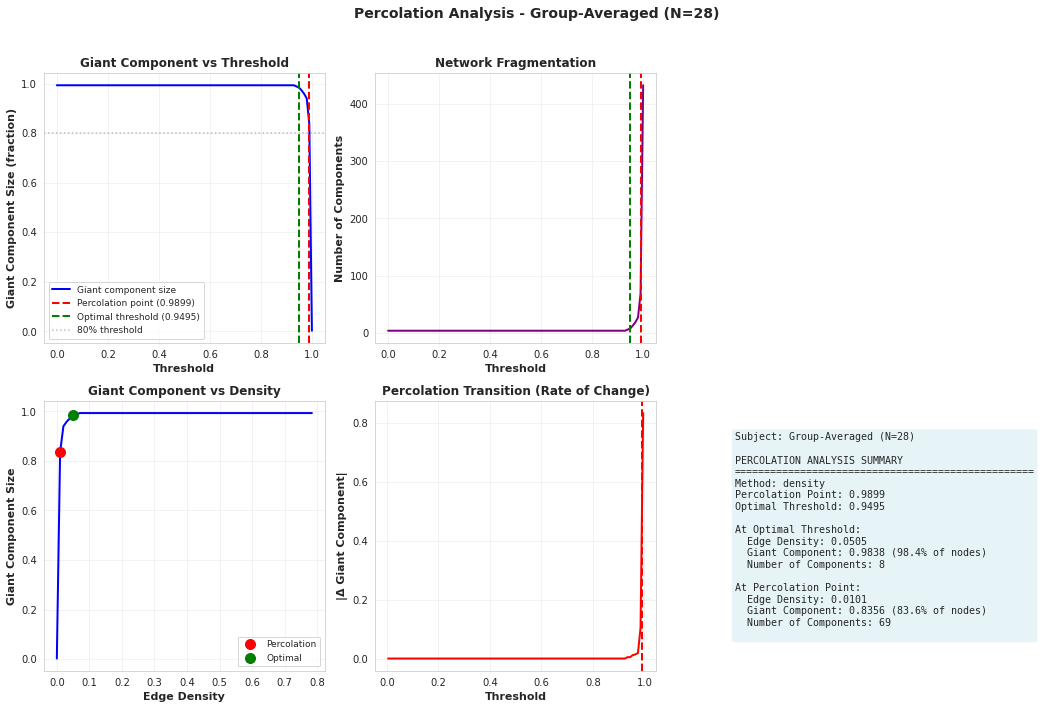

In [13]:
# ============================================================================
#  GROUP-AVERAGED PERCOLATION ANALYSIS 
# ============================================================================
# Based on Bordier et al. (2017)  
# Average connectomes , then perform percolation analysis
# ============================================================================
 

# Ensure we have the pattern defined  
if 'primary_pattern' not in locals() and 'primary_pattern' not in globals():
    primary_metric = 'SC_sift2_sizecorr'
    if 'METRICS_TO_ANALYZE' in locals() or 'METRICS_TO_ANALYZE' in globals():
        primary_pattern = METRICS_TO_ANALYZE[primary_metric]
    else:
        primary_pattern = '*_SC_sift2_sizecorr.csv'
    print(f"Note: Using pattern {primary_pattern}")

files = sorted(glob.glob(os.path.join(DATA_DIR, primary_pattern), recursive=True))
 

if len(files) == 0:
    print(f"ERROR: No files found matching pattern: {primary_pattern}")
    print(f"Data directory: {DATA_DIR}")
else:
    # Extract subject IDs
    subjects = [os.path.basename(f).split('_')[0] for f in files]
    print(f"Subjects: {', '.join(subjects)}")
    
 
    group_connectomes = []
    loaded_subjects = []
 
    print(f"\nLoading connectomes (using file handle approach)...")
    for i, (file_path, subject) in enumerate(zip(files, subjects)):
        try:
            with open(file_path, 'r') as f:
                M = np.loadtxt(f, delimiter=',')
            
            # Ensure symmetric and zero diagonal
            M = 0.5 * (M + M.T)
            np.fill_diagonal(M, 0.0)
            M = np.nan_to_num(M, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Check shape consistency
            if len(group_connectomes) > 0:
                if M.shape != group_connectomes[0].shape:
                    print(f"  [{i+1}/{len(files)}] {subject}: Shape mismatch {M.shape} vs {group_connectomes[0].shape} - skipping")
                    continue
            
            group_connectomes.append(M)
            loaded_subjects.append(subject)
            print(f"  [{i+1}/{len(files)}] ✓ {subject}: shape {M.shape}")
            
        except Exception as e:
            print(f"  [{i+1}/{len(files)}] ✗ {subject}: Error - {str(e)[:100]}")
            continue
    
    if len(group_connectomes) == 0:
        print("\nERROR: No connectomes could be loaded!")
    else:
        # Average across subjects
        print(f"\nAveraging {len(group_connectomes)} connectomes...")
        group_connectome = np.mean(np.array(group_connectomes), axis=0)
        group_connectome = np.nan_to_num(group_connectome, nan=0.0, posinf=0.0, neginf=0.0)
        
        
        # Perform percolation analysis on group-averaged connectome
        print("\n" + "="*70)
        print("PERFORMING PERCOLATION ANALYSIS ON GROUP-AVERAGED CONNECTOME")
        print("="*70)
        
        group_results = percolation_analysis(
            group_connectome,
            method=THRESHOLD_METHOD,
            target_density=None  # Set to 0.15 if you want to use target density
        )
        
        # Print summary
        opt_idx = np.argmin(np.abs(group_results['thresholds'] - group_results['optimal_threshold']))
        percol_idx = np.argmin(np.abs(group_results['thresholds'] - group_results['percolation_point']))
        
        print(f"\n✓ Percolation analysis complete!")
        print(f"\nResults for Group-Averaged Connectome (N={len(loaded_subjects)} subjects):")
        print(f"  Optimal threshold: {group_results['optimal_threshold']:.4f}")
        print(f"    → Edge density: {group_results['densities'][opt_idx]:.4f}")
        print(f"    → Giant component: {group_results['giant_component_sizes'][opt_idx]:.4f} ({group_results['giant_component_sizes'][opt_idx]*100:.1f}% of nodes)")
        print(f"    → Number of components: {group_results['n_components'][opt_idx]}")
        print(f"\n  Percolation point: {group_results['percolation_point']:.4f}")
        print(f"    → Edge density: {group_results['densities'][percol_idx]:.4f}")
        print(f"    → Giant component: {group_results['giant_component_sizes'][percol_idx]:.4f} ({group_results['giant_component_sizes'][percol_idx]*100:.1f}% of nodes)")
        print(f"    → Number of components: {group_results['n_components'][percol_idx]}")
        
        # Visualize results
        print("\n" + "="*70)
        print("VISUALIZING GROUP-AVERAGED PERCOLATION ANALYSIS")
        print("="*70)
        plot_percolation_results(group_results, subject_id=f"Group-Averaged (N={len(loaded_subjects)})")
        
        # Store for comparison (used in next cell)
        group_opt_threshold = group_results['optimal_threshold']
        group_percolation = group_results['percolation_point']
